# 图片增强
AletNet 当年能取得巨大的成功，其中图片增强功不可没。图片增强通过一系列的随机变化生成大量“新”的样本，从而减低过拟合的可能。现在在深度卷积神经网络中，图片增强是必不可少的一部分。

# 常用的增强方法

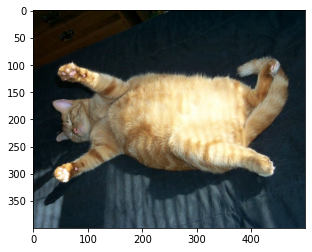

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from mxnet import image 
img=image.imdecode(open('../img/cat1.jpg','rb').read())
plt.imshow(img.asnumpy())